#### Section 1: Importing Necessary Libraries

In [27]:
### Basic Imports
import numpy as np
import pandas as pd
import random
import toml
import os
import logging
import math
import json
from datetime import datetime
import seaborn as sns
### Matplot Lib Imports
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

### Parallel Processing Libraries
from functools import partial
import time
from concurrent.futures import ProcessPoolExecutor, as_completed,ThreadPoolExecutor
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import concurrent.futures

### Scipy Imports
from scipy.spatial import distance
from shapely.geometry import Point, MultiPoint
from shapely.ops import cascaded_union
from scipy.spatial import distance
from sklearn.cluster import KMeans
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.spatial.distance import cdist
### Other Imports
import warnings
from copy import deepcopy
from dataclasses import dataclass, field
from typing import List, Dict, Tuple, Any
from abc import ABC, abstractmethod
from matplotlib.colors import LinearSegmentedColormap


#### Section 1.1: Basic Utility Functions

In [28]:
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((np.array(point1) - np.array(point2)) ** 2))

def create_distance_matrix(locations):
    n = len(locations)
    matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            matrix[i][j] = euclidean_distance(locations[i], locations[j])
    return matrix

def create_charging_distance_matrix(locations, charging_stations):
    matrix = np.zeros((len(locations), len(charging_stations)))
    for i, loc in enumerate(locations):
        for j, station in enumerate(charging_stations):
            matrix[i][j] = euclidean_distance(loc, station)
    return matrix

In [29]:
class EVRPSolution:
    def __init__(self):
        self.routes = []
        self.vehicle_types = []
        self.route_loads = []
        self.route_distances = []
        self.route_energies = []
        self.delivery_times = []
        self.computation_time = 0.0

    def add_route(self, route, vehicle_type, load):
        self.routes.append(route)
        self.vehicle_types.append(vehicle_type)
        self.route_loads.append(load)

In [30]:
class EVConfig:
    def __init__(self):
        self.categories = {
            'small': {
                'battery_capacity': 35,
                'base_weight': 1500,
                'load_capacity': 500
            },
            'medium': {
                'battery_capacity': 40,
                'base_weight': 1800,
                'load_capacity': 600
            },
            'large': {
                'battery_capacity': 45,
                'base_weight': 2000,
                'load_capacity': 700
            },
            'xlarge': {
                'battery_capacity': 50,
                'base_weight': 2200,
                'load_capacity': 800
            }
        }
        self.initial_charging = 100
        self.speed = 25
        self.energy_consumption_rate = 0.15
        self.weight_factor = 0.05
        self.battery_safety_margin = 20

In [31]:
class EVRPInstance:
    def __init__(self, instance_id, depot_location, customer_locations, 
                 charging_stations, customer_items_weights, charging_rate):
        self.instance_id = instance_id
        self.depot_location = depot_location
        self.customer_locations = customer_locations
        self.charging_stations = charging_stations
        self.customer_items_weights = customer_items_weights
        self.charging_rate = charging_rate
        
        # Create distance matrices
        self.distance_matrix = self._create_distance_matrix()
        self.charging_distance_matrix = self._create_charging_distance_matrix()

    def _create_distance_matrix(self):
        locations = [self.depot_location] + self.customer_locations
        return create_distance_matrix(locations)

    def _create_charging_distance_matrix(self):
        locations = [self.depot_location] + self.customer_locations
        return create_charging_distance_matrix(locations, self.charging_stations)

In [47]:
class GreedyEVRPSolver:
    def __init__(self, instance: EVRPInstance):
        self.instance = instance
        self.ev_config = EVConfig()
        self.best_solution = EVRPSolution()
        self.served_customers = set()  # Track globally served customers

    def create_route(self, unserved_customers, vehicle_type='medium'):
        """Creates a single route using greedy approach with capacity constraints"""
        if not unserved_customers:
            return [], 0
            
        route = [0]  # Start from depot
        current_load = 0
        vehicle_specs = self.ev_config.categories[vehicle_type]
        max_capacity = vehicle_specs['load_capacity']
        
        # Make a copy of unserved customers to modify
        available_customers = [c for c in unserved_customers 
                             if c not in self.served_customers]
        
        while available_customers:
            current_pos = route[-1]
            best_next = None
            best_distance = float('inf')
            
            # Find nearest unserved customer that fits in vehicle
            for customer_idx in available_customers:
                if customer_idx in self.served_customers:
                    continue
                    
                customer_id = customer_idx + 1  # Convert to 1-based indexing
                distance = self.calculate_distance(current_pos, customer_id)
                customer_demand = self.instance.customer_items_weights[customer_idx]
                
                # Check if adding this customer is feasible
                if current_load + customer_demand <= max_capacity * 0.95:  # 95% of capacity as threshold
                    if distance < best_distance:
                        best_next = customer_idx
                        best_distance = distance
            
            if best_next is None:
                break
                
            # Add customer to route
            customer_id = best_next + 1
            route.append(customer_id)
            current_load += self.instance.customer_items_weights[best_next]
            self.served_customers.add(best_next)  # Mark as globally served
            available_customers.remove(best_next)
            
            # Break if load is getting too high
            if current_load > max_capacity * 0.9:  # 90% of capacity as threshold
                break
        
        route.append(0)  # Return to depot
        return route, current_load

    def solve(self):
        """Implements greedy algorithm to solve EVRP with multiple vehicles"""
        start_time = time.time()
        
        # Reset served customers
        self.served_customers = set()
        
        # Initialize solution
        solution = EVRPSolution()
        unserved = list(range(len(self.instance.customer_locations)))
        
        # Keep creating routes until all customers are served
        while len(self.served_customers) < len(self.instance.customer_locations):
            # Print progress
            remaining = len(self.instance.customer_locations) - len(self.served_customers)
            print(f"Remaining customers to serve: {remaining}")
            
            # Select vehicle type based on remaining demand
            vehicle_type = self.select_vehicle_type(
                [c for c in unserved if c not in self.served_customers]
            )
            
            # Create new route with selected vehicle type
            route, load = self.create_route(unserved, vehicle_type)
            
            if not route or len(route) <= 2:  # No feasible route found or only depot-depot
                break
                
            # Insert charging stations
            route_with_charging = self.insert_charging_stations(route, load, vehicle_type)
            
            # Calculate route metrics
            distance, energy, delivery_time = self.calculate_route_metrics(
                route_with_charging, load, vehicle_type)
            
            # Update solution
            solution.add_route(route_with_charging, vehicle_type, load)
            solution.route_distances.append(distance)
            solution.route_energies.append(energy)
            solution.delivery_times.append(delivery_time)

        # Verify no duplicates in solution
        self.verify_solution(solution)
        
        solution.computation_time = time.time() - start_time
        return solution

    def verify_solution(self, solution):
        """Verify solution validity"""
        served = set()
        duplicates = []
        
        for route_idx, route in enumerate(solution.routes):
            for loc in route:
                if loc > 0:  # Customer location
                    if loc in served:
                        duplicates.append((loc, route_idx))
                    served.add(loc)
        
        if duplicates:
            print("WARNING: Duplicate customers found:")
            for cust, route in duplicates:
                print(f"Customer {cust} appears in route {route}")
            
        missing = set(range(1, len(self.instance.customer_locations) + 1)) - served
        if missing:
            print("WARNING: Unserved customers:", missing)
            
        return len(duplicates) == 0 and len(missing) == 0

    def select_vehicle_type(self, remaining_customers):
        """Select appropriate vehicle type based on remaining demands"""
        if not remaining_customers:
            return 'small'
            
        # Calculate remaining demands
        remaining_demands = [self.instance.customer_items_weights[i] 
                           for i in remaining_customers]
        max_demand = max(remaining_demands) if remaining_demands else 0
        avg_demand = sum(remaining_demands) / len(remaining_demands) if remaining_demands else 0
        
        # Select vehicle based on demand
        if max_demand <= self.ev_config.categories['small']['load_capacity'] * 0.8:
            return 'small'
        elif max_demand <= self.ev_config.categories['medium']['load_capacity'] * 0.8:
            return 'medium'
        elif max_demand <= self.ev_config.categories['large']['load_capacity'] * 0.8:
            return 'large'
        else:
            return 'xlarge'

        

    def insert_charging_stations(self, route, load, vehicle_type):
        """Inserts charging stations when needed based on energy consumption"""
        if len(route) <= 2:  # Only depot-customer-depot
            return route
            
        new_route = [0]  # Start at depot
        current_battery = self.ev_config.initial_charging
        vehicle_specs = self.ev_config.categories[vehicle_type]
        current_load = load
        
        for i in range(1, len(route)):
            from_loc = route[i-1]
            to_loc = route[i]
            
            # Calculate energy needed for next leg
            distance = self.calculate_distance(from_loc, to_loc)
            energy_needed = self.calculate_energy_consumption(distance, current_load, vehicle_type)
            
            # Check if charging is needed
            if current_battery - energy_needed < self.ev_config.battery_safety_margin:
                # Find nearest charging station
                charging_station = self.find_nearest_charging_station(new_route[-1])
                new_route.append(charging_station)
                current_battery = self.ev_config.initial_charging
                
                # Recalculate energy needed from charging station
                distance = self.calculate_distance(charging_station, to_loc)
                energy_needed = self.calculate_energy_consumption(distance, current_load, vehicle_type)
            
            new_route.append(to_loc)
            current_battery -= energy_needed
            
            # Update load after delivery (if it's a customer)
            if to_loc > 0:
                current_load -= self.instance.customer_items_weights[to_loc-1]
        
        return new_route

    def calculate_energy_consumption(self, distance, load, vehicle_type):
        """Calculate energy consumption for a given distance and load"""
        vehicle_specs = self.ev_config.categories[vehicle_type]
        total_weight = vehicle_specs['base_weight'] + load
        return distance * (self.ev_config.energy_consumption_rate + 
                         (total_weight * self.ev_config.weight_factor/1000))

    def calculate_route_metrics(self, route, load, vehicle_type):
        """Calculate distance, energy consumption, and delivery time for a route"""
        total_distance = 0
        total_energy = 0
        total_time = 0
        current_load = load
        
        for i in range(len(route) - 1):
            from_loc = route[i]
            to_loc = route[i + 1]
            
            distance = self.calculate_distance(from_loc, to_loc)
            energy = self.calculate_energy_consumption(distance, current_load, vehicle_type)
            
            total_distance += distance
            total_energy += energy
            
            # Add travel time
            total_time += distance / self.ev_config.speed
            
            # Add charging time if at charging station
            if from_loc < 0:  # At charging station
                charging_time = (self.ev_config.categories[vehicle_type]['battery_capacity'] / 
                               self.instance.charging_rate)
                total_time += charging_time
            
            # Update load after delivery
            if to_loc > 0:  # Delivering to customer
                current_load -= self.instance.customer_items_weights[to_loc-1]
        
        return total_distance, total_energy, total_time

    def calculate_distance(self, from_location, to_location):
        """Calculate distance between two locations"""
        if from_location >= 0 and to_location >= 0:
            return self.instance.distance_matrix[from_location][to_location]
        elif from_location < 0:  # From charging station
            charging_station_index = -from_location - 1
            return self.instance.charging_distance_matrix[to_location][charging_station_index]
        else:  # To charging station
            charging_station_index = -to_location - 1
            return self.instance.charging_distance_matrix[from_location][charging_station_index]

Loading data from /Users/chanakyavasantha/Comsets/test_cases/customers_30/c30_3.toml...

Problem Instance Details:
Instance ID: c30_3
Number of Customers: 30
Number of Charging Stations: 10
Total Delivery Weight: 2295 kg
Charging Rate: 22 kWh/h

Initializing Greedy EVRP Solver...
Solving problem...
Remaining customers to serve: 30
Remaining customers to serve: 24
Remaining customers to serve: 18
Remaining customers to serve: 12
Remaining customers to serve: 6
Remaining customers to serve: 1

=== Solution Details ===
Total routes (vehicles used): 6

Route 1:
Vehicle Type: SMALL
Load: 445.00 kg
Sequence: D → C2 → C9 → C12 → C24 → C22 → C23 → D
Distance: 123.47 km
Energy: 28.94 kWh
Time: 4.94 hours
Customers served: 6
Charging stops: 0

Route 2:
Vehicle Type: SMALL
Load: 440.00 kg
Sequence: D → C11 → C6 → C3 → C21 → C7 → C5 → D
Distance: 130.72 km
Energy: 30.54 kWh
Time: 5.23 hours
Customers served: 6
Charging stops: 0

Route 3:
Vehicle Type: SMALL
Load: 435.00 kg
Sequence: D → C4 → C27 →

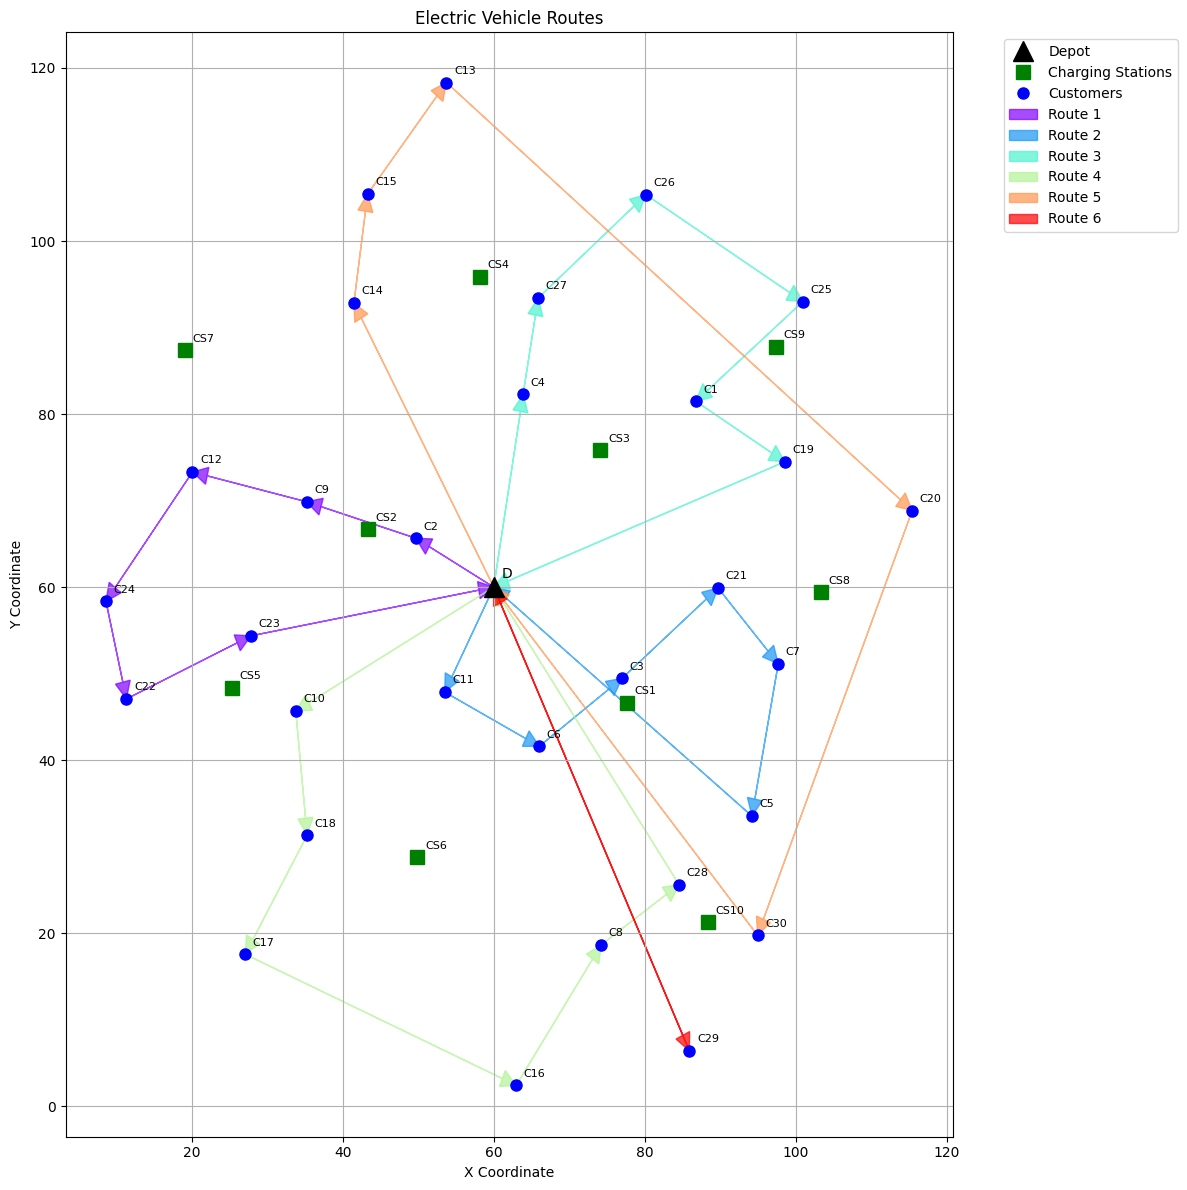

In [51]:
import toml
import numpy as np
import matplotlib.pyplot as plt
import time
import os

def read_toml_input(file_path):
    """Read EVRP instance data from TOML file"""
    try:
        data = toml.load(file_path)
        
        # Extract required fields
        instance = {
            'instance_id': os.path.basename(file_path).split('.')[0],
            'depot_location': data['depot_location'],
            'customer_locations': data['customer_locations'],
            'charging_stations': data['charging_stations'],
            'customer_items_weights': data['customer_items_weights'],
            'charging_rate': data['charging_rate'],
            'vehicle_speed': data.get('vehicle_speed', 25),  # default if not specified
            'ev_parameters': data.get('ev_parameters', None)
        }
        
        # Validate data
        validate_input_data(instance)
        return instance
        
    except Exception as e:
        raise Exception(f"Error reading TOML file: {str(e)}")

def validate_input_data(instance):
    """Validate the input data format and constraints"""
    # Check if all required fields exist
    required_fields = ['instance_id', 'depot_location', 'customer_locations', 
                      'charging_stations', 'customer_items_weights', 'charging_rate']
    
    for field in required_fields:
        if field not in instance:
            raise ValueError(f"Missing required field: {field}")
    
    # Validate dimensions
    if len(instance['depot_location']) != 2:
        raise ValueError("Depot location must be a 2D point")
    
    if not all(len(loc) == 2 for loc in instance['customer_locations']):
        raise ValueError("All customer locations must be 2D points")
        
    if not all(len(loc) == 2 for loc in instance['charging_stations']):
        raise ValueError("All charging station locations must be 2D points")
        
    # Check if number of weights matches number of customers
    if len(instance['customer_items_weights']) != len(instance['customer_locations']):
        raise ValueError("Number of weights must match number of customers")
        
    # Validate numeric values
    if instance['charging_rate'] <= 0:
        raise ValueError("Charging rate must be positive")
        
    if any(w <= 0 for w in instance['customer_items_weights']):
        raise ValueError("All customer weights must be positive")

def run_ev_routing(toml_file_path):
    """Main function to run EV routing problem"""
    print(f"Loading data from {toml_file_path}...")
    
    # Read and validate input
    instance_data = read_toml_input(toml_file_path)
    
    # Create problem instance
    instance = EVRPInstance(
        instance_id=instance_data['instance_id'],
        depot_location=instance_data['depot_location'],
        customer_locations=instance_data['customer_locations'],
        charging_stations=instance_data['charging_stations'],
        customer_items_weights=instance_data['customer_items_weights'],
        charging_rate=instance_data['charging_rate']
    )
    
    # Print problem details
    print("\nProblem Instance Details:")
    print(f"Instance ID: {instance_data['instance_id']}")
    print(f"Number of Customers: {len(instance_data['customer_locations'])}")
    print(f"Number of Charging Stations: {len(instance_data['charging_stations'])}")
    print(f"Total Delivery Weight: {sum(instance_data['customer_items_weights'])} kg")
    print(f"Charging Rate: {instance_data['charging_rate']} kWh/h")
    
    # Create and run solver
    print("\nInitializing Greedy EVRP Solver...")
    solver = GreedyEVRPSolver(instance)
    
    print("Solving problem...")
    solution = solver.solve()
    
    # Print solution
    print("\n=== Solution Details ===")
    print(f"Total routes (vehicles used): {len(solution.routes)}")
    
    vehicle_counts = {}
    total_distance = 0
    total_energy = 0
    total_customers = 0
    
    for i, (route, v_type, load, distance, energy, time) in enumerate(zip(
            solution.routes, solution.vehicle_types, solution.route_loads,
            solution.route_distances, solution.route_energies, solution.delivery_times)):
        
        # Update vehicle counts
        vehicle_counts[v_type] = vehicle_counts.get(v_type, 0) + 1
        
        print(f"\nRoute {i+1}:")
        print(f"Vehicle Type: {v_type.upper()}")
        print(f"Load: {load:.2f} kg")
        
        # Convert route to readable format
        route_str = []
        for loc in route:
            if loc == 0:
                route_str.append("D")  # Depot
            elif loc > 0:
                route_str.append(f"C{loc}")  # Customer
            else:
                route_str.append(f"CS{-loc}")  # Charging Station
        print("Sequence:", ' → '.join(route_str))
        
        print(f"Distance: {distance:.2f} km")
        print(f"Energy: {energy:.2f} kWh")
        print(f"Time: {time:.2f} hours")
        
        num_customers = sum(1 for loc in route if loc > 0)
        num_charges = sum(1 for loc in route if loc < 0)
        print(f"Customers served: {num_customers}")
        print(f"Charging stops: {num_charges}")
        
        total_distance += distance
        total_energy += energy
        total_customers += num_customers
    
    # Print summary statistics
    print("\n=== Overall Statistics ===")
    print("Vehicle Distribution:")
    for v_type, count in vehicle_counts.items():
        print(f"{v_type.upper()}: {count} vehicles")
        
    print(f"\nTotal distance: {total_distance:.2f} km")
    print(f"Total energy consumption: {total_energy:.2f} kWh")
    print(f"Average energy per km: {total_energy/total_distance:.3f} kWh/km")
    print(f"Total customers served: {total_customers}")
    print(f"Average distance per customer: {total_distance/total_customers:.2f} km")
    print(f"Computation time: {solution.computation_time:.2f} seconds")
    
    # Plot solution
    print("\nGenerating visualization...")
    plt.figure(figsize=(12, 12))
    
    # Plot depot
    plt.plot(instance.depot_location[0], instance.depot_location[1], 
            'k^', markersize=15, label='Depot')
    plt.text(instance.depot_location[0] + 1, instance.depot_location[1] + 1, 
            'D', fontsize=10)
    
    # Plot charging stations
    charging_stations = np.array(instance.charging_stations)
    plt.plot(charging_stations[:, 0], charging_stations[:, 1], 
            'gs', markersize=10, label='Charging Stations')
    for i, (x, y) in enumerate(charging_stations):
        plt.text(x + 1, y + 1, f'CS{i+1}', fontsize=8)
    
    # Plot customers with numbers
    customers = np.array(instance.customer_locations)
    plt.plot(customers[:, 0], customers[:, 1], 
            'bo', markersize=8, label='Customers')
    for i, (x, y) in enumerate(customers):
        plt.text(x + 1, y + 1, f'C{i+1}', fontsize=8)
    
    # Plot routes with arrows to show direction
    colors = plt.cm.rainbow(np.linspace(0, 1, len(solution.routes)))
    all_locations = [instance.depot_location] + instance.customer_locations
    
    for route_idx, (route, color) in enumerate(zip(solution.routes, colors)):
        for i in range(len(route) - 1):
            # Get coordinates for current segment
            if route[i] >= 0:
                start = all_locations[route[i]]
            else:
                start = instance.charging_stations[-route[i]-1]
                
            if route[i+1] >= 0:
                end = all_locations[route[i+1]]
            else:
                end = instance.charging_stations[-route[i+1]-1]
            
            # Draw arrow
            plt.arrow(start[0], start[1], 
                     end[0] - start[0], end[1] - start[1],
                     head_width=2, head_length=2, fc=color, ec=color,
                     length_includes_head=True, alpha=0.7,
                     label=f'Route {route_idx+1}' if i == 0 else "")
    
    plt.title('Electric Vehicle Routes')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.grid(True)
    
    # Move legend outside plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    return solver, solution
        

if __name__ == "__main__":
    # Example usage
    toml_path = "/Users/chanakyavasantha/Comsets/test_cases/customers_30/c30_3.toml"
    solver, solution = run_ev_routing(toml_path)